In [65]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import keras
import pickle
from keras.models import load_model

%matplotlib inline
warnings.filterwarnings("ignore")

# A glance at the data

In [66]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [67]:
display(df_train.info())
display(df_train.head())
display(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   week_id                 553 non-null    int64 
 1   date                    553 non-null    object
 2   sessions                553 non-null    int64 
 3   online_leads_actuals    553 non-null    int64 
 4   test_drive_request      553 non-null    int64 
 5   offer_request           553 non-null    int64 
 6   total_configs_finished  553 non-null    int64 
 7   keep_me_updated         553 non-null    int64 
 8   dealer_locator          553 non-null    int64 
 9   private_orders          553 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 43.3+ KB


None

,week_id,date,sessions,online_leads_actuals,test_drive_request,offer_request,total_configs_finished,keep_me_updated,dealer_locator,private_orders
0,1,01/01/2017,15038,29,12,17,989,0,2457,0
1,1,02/01/2017,19200,34,20,14,1261,2,3457,0
2,1,03/01/2017,28097,68,56,12,1878,5,4859,27
3,1,04/01/2017,24711,69,39,30,1648,2,4825,16
4,1,05/01/2017,27025,90,53,37,1939,2,5219,6


,week_id,sessions,online_leads_actuals,test_drive_request,offer_request,total_configs_finished,keep_me_updated,dealer_locator,private_orders
count,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000
mean,40.000000,25421.696203,84.396022,55.989150,28.406872,2276.397830,26.537071,3550.169982,33.455696
std,22.824155,7364.773546,49.295623,45.517116,17.813316,1193.323702,61.093500,1110.030624,44.913547
min,1.000000,11790.000000,9.000000,6.000000,3.000000,908.000000,0.000000,973.000000,0.000000
25%,20.000000,19838.000000,59.000000,33.000000,19.000000,1356.000000,1.000000,2885.000000,6.000000
50%,40.000000,23631.000000,79.000000,51.000000,25.000000,1828.000000,15.000000,3329.000000,18.000000
75%,60.000000,29681.000000,100.000000,69.000000,34.000000,3016.000000,30.000000,4093.000000,44.000000
max,79.000000,74880.000000,818.000000,798.000000,216.000000,6730.000000,974.000000,10681.000000,453.000000


Since, date is a string, better to convert into datetime format for better analysis.

In [68]:
df_train['date'] = pd.to_datetime(df_train['date'], format = '%d/%m/%Y')
df_test['date'] = pd.to_datetime(df_test['date'], format = '%d/%m/%Y')

In [69]:
print('Minimum date from training set: {}'.format(df_train['date'].min()))
print('Maximum date from training set: {}'.format(df_train['date'].max()))

Minimum date from training set: 2017-01-01 00:00:00
Maximum date from training set: 2018-07-07 00:00:00


In [70]:
print('Minimum date from test set: {}'.format(df_test['date'].min()))
print('Maximum date from test set: {}'.format(df_test['date'].max()))

Minimum date from test set: 2018-07-08 00:00:00
Maximum date from test set: 2018-08-31 00:00:00


# Exploratory Data Analysis

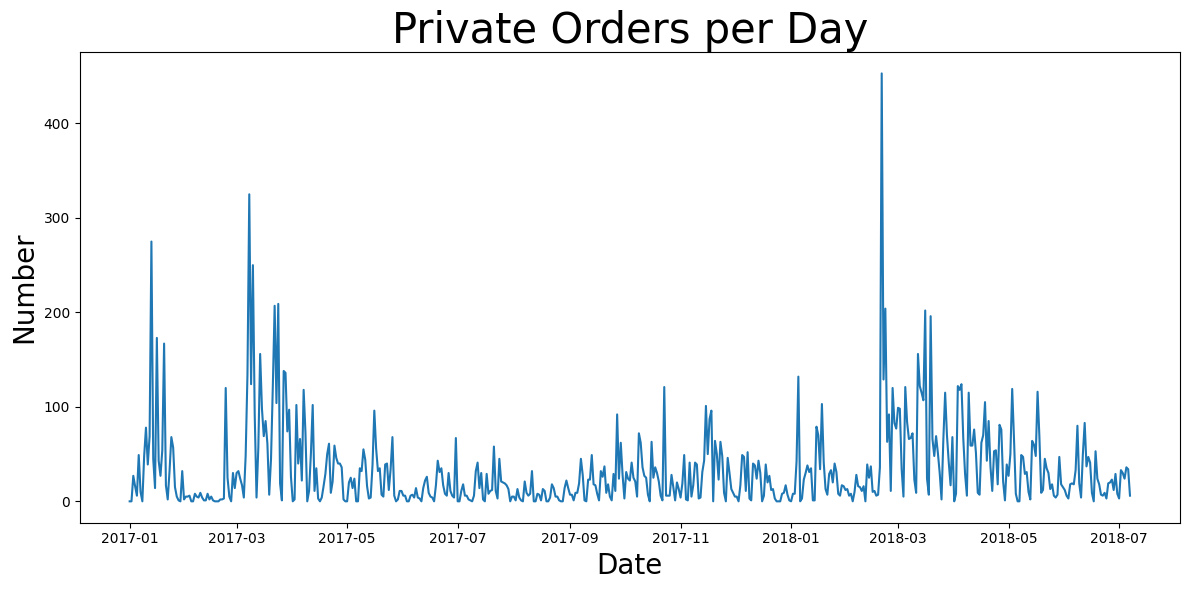

In [71]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(x="date", y="private_orders", data=df_train)
ax.set_title('Private Orders per Day', fontsize=30)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Number', fontsize=20)
plt.tight_layout()
plt.show()

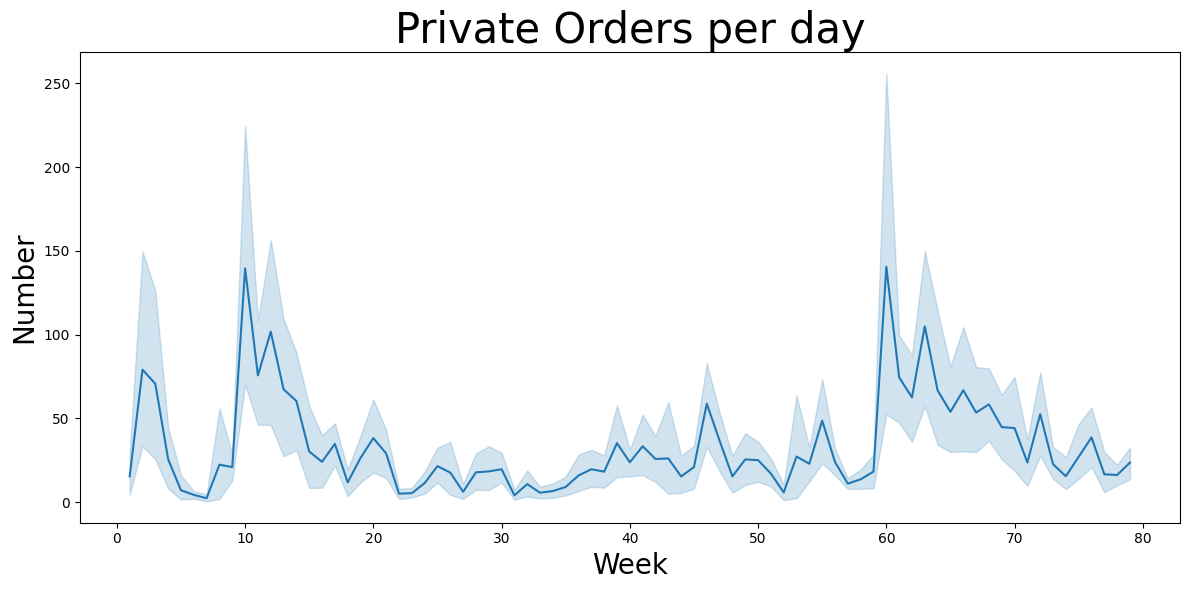

In [72]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(x="week_id", y="private_orders", data=df_train)
ax.set_title('Private Orders per day', fontsize=30)
ax.set_xlabel('Week', fontsize=20)
ax.set_ylabel('Number', fontsize=20)
plt.tight_layout()
plt.show()

>On studying the variation of number of private orders on both granularities: daily and weekly, It can be concluded that it has seasonality and noise. It doen't seem to have some sort of trend.

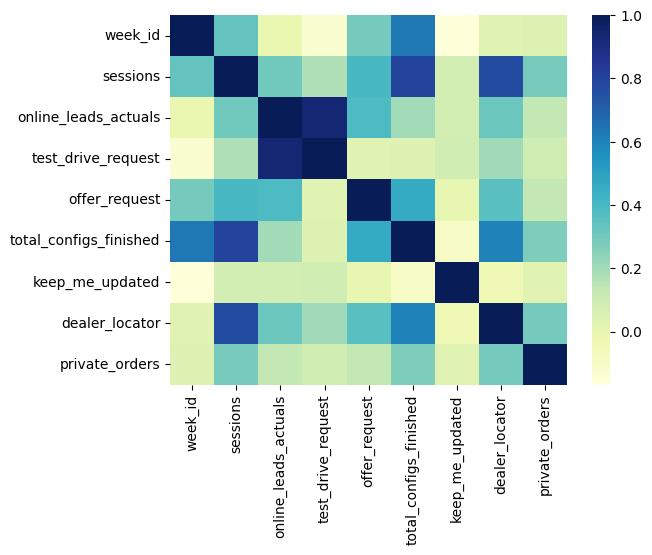

In [73]:
sns.heatmap(df_train.corr(), cmap='YlGnBu', annot_kws={'size': 20});

> The private_orders seems to be most positively correlated with sessions, total_configs_finished and dealer_locator. private_orders don't seem to be negatively correlated with none of the features.

# Preparing the data

In [74]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [75]:
#convert to an array
values = df_train.iloc[:,2:].values
#convert all columns to float
#values.astype('float32')
#normalize featues
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[range(56,63)], axis=1, inplace=True)
print(reframed.head())

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.051482   0.024722   0.007576   0.065728   0.013913   0.000000   
8    0.117451   0.030902   0.017677   0.051643   0.060632   0.002053   
9    0.258472   0.072930   0.063131   0.042254   0.166609   0.005133   
10   0.204803   0.074166   0.041667   0.126761   0.127104   0.002053   
11   0.241480   0.100124   0.059343   0.159624   0.177087   0.002053   

    var7(t-7)  var8(t-7)  var1(t-6)  var2(t-6)  ...  var8(t-2)  var1(t-1)  \
7    0.152864   0.000000   0.117451   0.030902  ...   0.108168   0.191536   
8    0.255871   0.000000   0.258472   0.072930  ...   0.022075   0.073799   
9    0.400288   0.059603   0.204803   0.074166  ...   0.000000   0.180250   
10   0.396786   0.035320   0.241480   0.100124  ...   0.105960   0.196782   
11   0.437371   0.013245   0.205738   0.097651  ...   0.172185   0.209098   

    var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
7    0.039555   0.021465   0.070

# Defining and Fitting the model

Since, we have the training data for 79 weeks. Lets, take 64 weeks of data for training the model and remaining 15 weeks for finding the best parameters(Cross-validation).

In [76]:
# split into train and test sets
values = reframed.values
n_train_days = 7*64 
train = values[:n_train_days, :]
dev = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
dev_X, dev_y = dev[:, :-1], dev[:, -1]
print(train_X.shape, train_y.shape, dev_X.shape, dev_y.shape)

(448, 56) (448,) (98, 56) (98,)


In [77]:
regressor = XGBRegressor()

In [78]:
regressor.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [79]:
#prediction on training data
training_data_prediction = regressor.predict(train_X)

In [80]:
# R-squared value
train_r2 = metrics.r2_score(train_y, training_data_prediction)

In [81]:
print('R-squared value = ', train_r2)

R-squared value =  0.9999705193060902


In [82]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 7, 8))
dev_X = dev_X.reshape((dev_X.shape[0], 7, 8))

For my model, I'll be an LSTM with 100 neurons in the first layer and a single neuron in the output layer for predicting the number of private orders per day. The model will be fit for 100 training epochs with a batch size of 128.

>All these values for epochs, batch_size and mae loss function are not taken randomly. I trained my model on multiple values and after hit and trial these are the best values i could get.

Epoch 1/20
4/4 - 3s - loss: 0.0657 - val_loss: 0.0564 - 3s/epoch - 724ms/step
Epoch 2/20
4/4 - 0s - loss: 0.0659 - val_loss: 0.0517 - 87ms/epoch - 22ms/step
Epoch 3/20
4/4 - 0s - loss: 0.0577 - val_loss: 0.0571 - 104ms/epoch - 26ms/step
Epoch 4/20
4/4 - 0s - loss: 0.0541 - val_loss: 0.0510 - 110ms/epoch - 27ms/step
Epoch 5/20
4/4 - 0s - loss: 0.0550 - val_loss: 0.0515 - 94ms/epoch - 23ms/step
Epoch 6/20
4/4 - 0s - loss: 0.0521 - val_loss: 0.0506 - 88ms/epoch - 22ms/step
Epoch 7/20
4/4 - 0s - loss: 0.0539 - val_loss: 0.0504 - 101ms/epoch - 25ms/step
Epoch 8/20
4/4 - 0s - loss: 0.0518 - val_loss: 0.0505 - 104ms/epoch - 26ms/step
Epoch 9/20
4/4 - 0s - loss: 0.0510 - val_loss: 0.0504 - 90ms/epoch - 22ms/step
Epoch 10/20
4/4 - 0s - loss: 0.0508 - val_loss: 0.0505 - 95ms/epoch - 24ms/step
Epoch 11/20
4/4 - 0s - loss: 0.0507 - val_loss: 0.0504 - 89ms/epoch - 22ms/step
Epoch 12/20
4/4 - 0s - loss: 0.0500 - val_loss: 0.0499 - 87ms/epoch - 22ms/step
Epoch 13/20
4/4 - 0s - loss: 0.0502 - val_loss

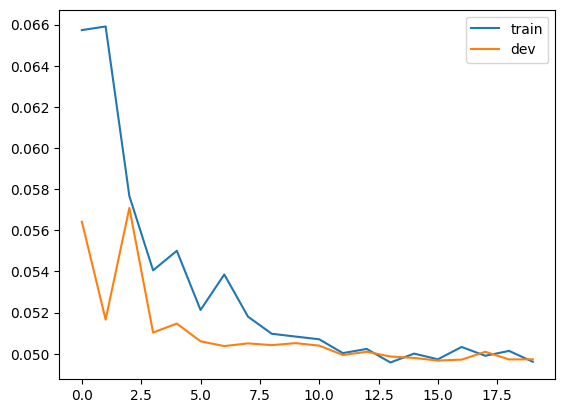

In [83]:
# design network
model = keras.models.Sequential()
model.add(keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=128, validation_data=(dev_X, dev_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [84]:
model.save('keras_model.h5')

# Predicting the values

Since, We are using the past day to predict the next day private orders, I'll add the last record from training set to help in predicting the values in the test set.

In [85]:
#take a backup for the submission file
submit = df_test.copy()
#Insert all zeroes for the values to be predicted.
df_test.insert(loc=9, column='private_orders', value=0)
df = df_test.append(df_train[-7:], ignore_index=True)
df.sort_values('week_id',inplace=True)
df = df.reset_index(drop=True)

Apply the same transformations to the test data as applied to the training data.

In [86]:
#convert to an array
values_test = df.iloc[:,2:].values
#convert all columns to float
#values_test.astype('float32')
#normalize featues
scaler_test = MinMaxScaler(feature_range=(0,1))
scaled_test = scaler_test.fit_transform(values_test)
# frame as supervised learning
reframed_test = series_to_supervised(scaled_test, 7, 1)
# drop columns we don't want to predict
reframed_test.drop(reframed_test.columns[range(56,63)], axis=1, inplace=True)
print(reframed_test.head())

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.428814   0.694915   0.883721   0.166667   0.072860   0.000000   
8    0.511683   0.237288   0.232558   0.200000   0.202793   0.000000   
9    0.495245   0.135593   0.232558   0.000000   0.219186   0.000000   
10   0.317756   0.474576   0.581395   0.166667   0.000000   0.000000   
11   0.392813   0.389831   0.418605   0.233333   0.177292   0.333333   

    var7(t-7)  var8(t-7)  var1(t-6)  var2(t-6)  ...  var8(t-2)  var1(t-1)  \
7    0.033047   0.166667   0.511683   0.237288  ...   0.083333   0.426301   
8    0.522141   1.000000   0.495245   0.135593  ...   0.944444   0.369515   
9    0.486451   0.666667   0.317756   0.474576  ...   0.000000   0.655142   
10   0.382683   0.833333   0.392813   0.389831  ...   0.000000   0.653444   
11   0.627231   0.916667   0.203573   0.423729  ...   0.000000   0.516166   

    var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
7    0.372881   0.372093   0.266

In [87]:
values_test = reframed_test.values
# split into input and outputs
test_X, test_y = values_test[:, :-1], values_test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], 7, 8))
print(test_X.shape, test_y.shape)

(55, 7, 8) (55,)


In [88]:
# make a prediction
yhat = model.predict(test_X)

2/2 [==============================] - 0s 7ms/step


In [89]:
test_X = test_X.reshape((test_X.shape[0], 7*8))
test_X.shape

(55, 56)

In [90]:
# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, -8:-1],yhat), axis=1)
inv_test = scaler_test.inverse_transform(inv_yhat)
inv_yhat = inv_test[:,-1]

In [91]:
np.around(inv_yhat)

array([16., 14., 11., 10.,  7.,  4.,  3.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  2.,
        1.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        3.,  3.,  4.])

In [92]:
#map all the values to integers
y = list(map(int,inv_yhat))

In [93]:
#Insert the predicted values
submit.insert(loc=9, column='private_orders', value=y)

In [94]:
#download the csv
submit.to_csv('csv_to_submit.csv', index = False)

In [95]:
pickle.dump(model.fit, open('car_sales_prediction_model.pkl', 'wb'))

**Flask Application**





In [96]:
pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [98]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template
import pickle
import numpy as np
from pyngrok import ngrok

In [100]:
port_no = 5000

In [101]:
from flask import Flask, request, jsonify
import pickle
from pyngrok import ngrok

app = Flask(__name__)

# load the trained machine learning model
with open('car_sales_prediction_model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/', methods=['GET'])
def home():
    return '''<h1>Car Sales Prediction API</h1>
<p>A prototype API for predicting car sales using a machine learning model.</p>'''

@app.route('/predict', methods=['POST'])
def predict():
    # get the request data
    data = request.get_json(force=True)

    # preprocess the input data
    # ...

    # make a prediction
    prediction = model.predict(data)

    # format the output
    output = {'prediction': int(prediction[0])}

    return jsonify(output)

if __name__ == '__main__':
    # create an ngrok tunnel for the Flask application
    ngrok_tunnel = ngrok.connect(port_no)

    # print the public URL of the ngrok tunnel
    print('Public URL:', ngrok_tunnel.public_url)

    # run the Flask application on the local development server
    app.run(port=port_no)


PyngrokNgrokHTTPError: ignored